# Multivariate Time Series Anomaly Detection

## boilerplate

In [29]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from torch import nn, optim

import torch.nn.functional as F
import random
import datetime
# from arff2pandas import a2p

In [30]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=0.7)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) 
 


In [31]:
import polars as pl
from io import StringIO
import math
df = pl.read_csv('../data/battery_1.csv')

We only need 'PACK1_CRIDATA_BATT_VOL'

## visualize fault and non-fault regions

In [32]:

input_data = df.select(['PACK1_CRIDATA_AVG_CELL_TEMP', 'PACK1_CRIDATA_AVG_CELL_VOL', 'PACK1_CRIDATA_BATT_VOL', 'PACK1_CRIDATA_SOC'])

In [33]:
# process explanatory variables
filter_condition =  df['PACK1_CRIDATA_BATT_VOL'].cast(pl.Float32) != 0
voltage_data = (df['PACK1_CRIDATA_BATT_VOL']
                .filter(filter_condition)
                .cast(pl.Float32))

input_data = (df.select(
    pl.col('PACK1_CRIDATA_AVG_CELL_TEMP').cast(pl.Float32), 
    pl.col('PACK1_CRIDATA_AVG_CELL_VOL').cast(pl.Float32),
    pl.col('PACK1_CRIDATA_BATT_VOL').cast(pl.Float32),
    pl.col('PACK1_CRIDATA_SOC').cast(pl.Float32),
    pl.col('PACK1_CRIDATA_CURR').cast(pl.Float32))
.filter(filter_condition))


In [34]:

def convert_values(values):
    numerical_values = []
    for value in values:
        if value == 'False':
            numerical_values.append(0)
        elif value == 'True':
            numerical_values.append(1)
        else:
            # numerical_values.append(np.nan)
            # numerical_values.append(-1)
            numerical_values.append(-1)
    return numerical_values


fault_data = convert_values(df['BATT_PACK_1_FAULT']
                            .filter(filter_condition))


Text(0.5, 1.0, 'fault incidents')

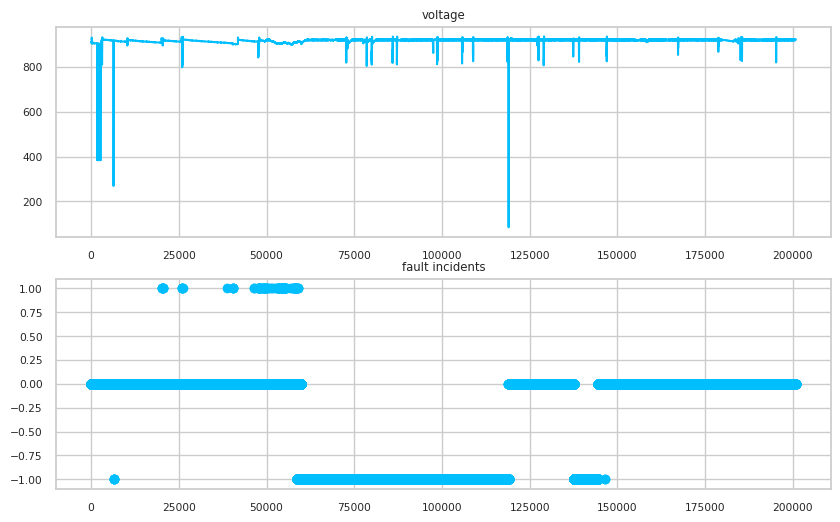

In [35]:

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,3 * 2))

axs[0].plot(voltage_data)
axs[0].set_title("voltage")
axs[1].scatter(range(len(fault_data)), fault_data)
axs[1].set_title("fault incidents")

In [36]:
df_std = input_data.select(
    ((pl.col('PACK1_CRIDATA_AVG_CELL_TEMP') - pl.col('PACK1_CRIDATA_AVG_CELL_TEMP').mean())/ pl.col('PACK1_CRIDATA_AVG_CELL_TEMP').std())
    .alias('PACK1_CRIDATA_AVG_CELL_TEMP'),
    ((pl.col('PACK1_CRIDATA_AVG_CELL_VOL') - pl.col('PACK1_CRIDATA_AVG_CELL_VOL').mean())/ pl.col('PACK1_CRIDATA_AVG_CELL_VOL').std())
    .alias('PACK1_CRIDATA_AVG_CELL_VOL'),
    ((pl.col('PACK1_CRIDATA_BATT_VOL') - pl.col('PACK1_CRIDATA_BATT_VOL').mean())/ pl.col('PACK1_CRIDATA_BATT_VOL').std())
    .alias('PACK1_CRIDATA_BATT_VOL'),
    ((pl.col('PACK1_CRIDATA_SOC') - pl.col('PACK1_CRIDATA_SOC').mean())/ pl.col('PACK1_CRIDATA_SOC').std())
    .alias('PACK1_CRIDATA_SOC'),
    ((pl.col('PACK1_CRIDATA_CURR') - pl.col('PACK1_CRIDATA_CURR').mean())/ pl.col('PACK1_CRIDATA_CURR').std())
    .alias('PACK1_CRIDATA_CURR'),

)

In [37]:
train_data = df_std[100000:]
test_data = df_std[60000:85000]
val_data = df_std[85000:100000]
anomaly_data = df_std[0:60000]

## Data Processing

In [38]:
train_data.to_numpy().shape

(100774, 5)

In [39]:
test_data.to_numpy().shape

(25000, 5)

In [40]:
def create_dataset(df, segment_size):
    # normalize the data
    data = df.to_numpy()
    # sliding window
    segments = [ torch.tensor(data[i:i + segment_size]).float() for i in range(0, len(data) - segment_size + 1, segment_size) ]
    # reject the last segment if it doesn't fit the shape
    if (segments[-1].shape[0] != segment_size):
        segments.pop()
    n_seq, seq_len, n_features = torch.stack(segments).shape

    return segments, seq_len, n_features


In [41]:
segment_size = 60
train_dataset, seq_len, n_features = create_dataset(train_data, segment_size)
val_dataset, _, _ = create_dataset(val_data, segment_size)
test_normal_dataset, _, _ = create_dataset(test_data, segment_size)
test_anomaly_dataset, _, _ = create_dataset(anomaly_data, segment_size)
whole_dataset, _, _ = create_dataset(df_std, segment_size)

## Encoder Decoder

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [43]:
x = val_dataset[0]
print(x.shape)
x = x.reshape((1, 60, 5))
x.shape

rnn_test_1 = nn.LSTM(  # 4
      input_size=5,
      # 64
      hidden_size=64 * 2,
      num_layers=1,
      batch_first=True
)

rnn_test_2 = nn.LSTM(  # 4
      input_size=64 * 2,
      # 64
      hidden_size=64,
      num_layers=1,
      batch_first=True
)

output, (_, _) = rnn_test_1(x)
output, (hidden, _) = rnn_test_2(output)

# output is [1, 60, 128]
# hidden is [1, 1, 128]
# we first expand [1, 60, 4] to [1, 60, 128]
# then squeeze to [1, 1, 128]
# effectively compressed time of 60 to 1 vector of size 128

torch.Size([60, 5])


In [44]:
hidden.shape

torch.Size([1, 1, 64])

In [45]:
x = hidden
x = x.repeat((1,60,1))
x.shape

torch.Size([1, 60, 64])

In [46]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64, num_layers=1):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.num_layers = num_layers

    self.rnn1 = nn.LSTM(
      # 4
      input_size=n_features,
      # 64
      hidden_size=self.hidden_dim,
      num_layers=self.num_layers,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      # 64
      input_size=self.hidden_dim,
      # 128
      hidden_size=embedding_dim,
      num_layers=self.num_layers,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    # hidden_n is 128 here
    # but we only have 128 values

    # return hidden_n.reshape((self.n_features, self.embedding_dim))
    # hidden_n has same size as embedding_dim
    return hidden_n.reshape(self.num_layers * self.embedding_dim)

In [47]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1, num_layers=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.num_layers = num_layers

    self.rnn1 = nn.LSTM(
      # embedding_dim = 64
      # input_dim = 64
      input_size=num_layers * input_dim,
      hidden_size=input_dim,
      num_layers=self.num_layers,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      # input_dim = 64
      input_size=input_dim,
      # hidden_size = 64 * 2
      hidden_size=self.hidden_dim,
      num_layers=self.num_layers,
      batch_first=True
    )

    # input: hidden_dim = 2 * 64
    # output: n_features = 4
    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    
    # x = x.repeat(self.n_features, self.seq_len, 1)
    # x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x = x.repeat(1, self.seq_len, 1)

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [48]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64, num_layers=1):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim, num_layers).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features, num_layers).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [49]:
model = RecurrentAutoencoder(seq_len, n_features, embedding_dim=64, num_layers=1)
model = model.to(device)

## Training

In [50]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [51]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=100
)

Epoch 1: train loss 38.86843705290907 val loss 31.42728550720215
Epoch 2: train loss 33.15285356688031 val loss 30.997470954895018
Epoch 3: train loss 30.248853377602938 val loss 26.995422161102294
Epoch 4: train loss 20.282794476549423 val loss 23.825604535102844
Epoch 5: train loss 16.377526552212814 val loss 24.040671655654908
Epoch 6: train loss 15.591873613832393 val loss 23.611765365600586
Epoch 7: train loss 15.221078222887085 val loss 23.626889554977417
Epoch 8: train loss 14.928746445538247 val loss 23.297098026275634
Epoch 9: train loss 14.680893610814556 val loss 22.969089159965517
Epoch 10: train loss 14.512633638058198 val loss 23.19877135181427
Epoch 11: train loss 14.2985059658355 val loss 23.137717478752137
Epoch 12: train loss 14.14401307029338 val loss 22.674271161079407
Epoch 13: train loss 13.994837189089903 val loss 23.112126132965088
Epoch 14: train loss 13.851284402903522 val loss 23.070360283851624
Epoch 15: train loss 13.70330542975625 val loss 22.4951132955551

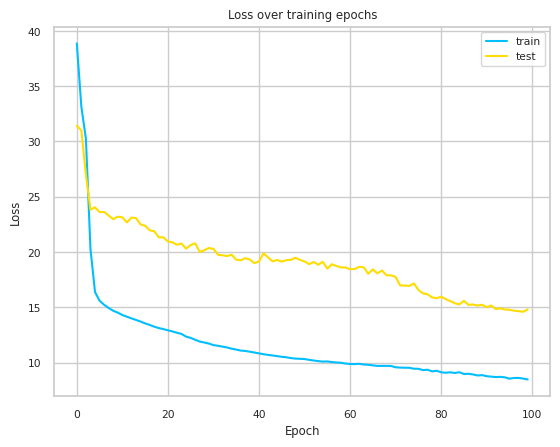

In [52]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

## Save the model


In [53]:
date = datetime.date.today().strftime('%y-%m-%d')
MODEL_PATH = f'model_save/multivar_model_{date}_01.pth'

torch.save(model, MODEL_PATH)

## Check reconstruction error

In [54]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [55]:
_, losses = predict(model, test_normal_dataset)

<Axes: ylabel='Density'>

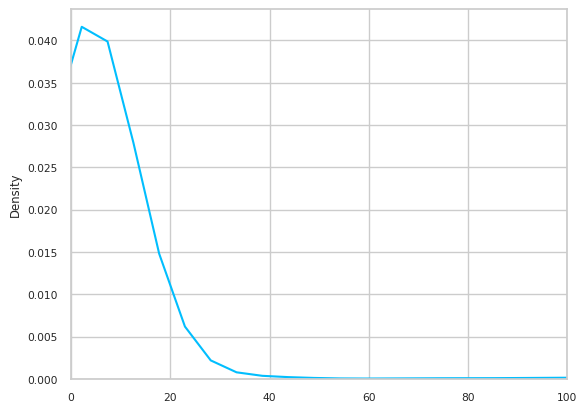

In [56]:
_, losses = predict(model, train_dataset)
plt.xlim(0, 100)
sns.kdeplot(losses)

<Axes: ylabel='Density'>

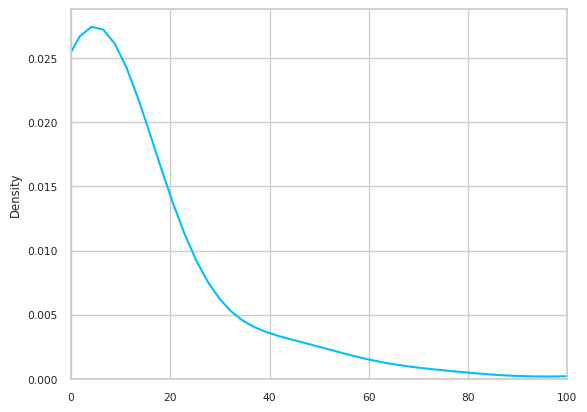

In [57]:
# _, losses = predict(model, train_dataset)
_, losses = predict(model, test_normal_dataset)
plt.xlim(0, 100)
sns.kdeplot(losses)

<Axes: ylabel='Density'>

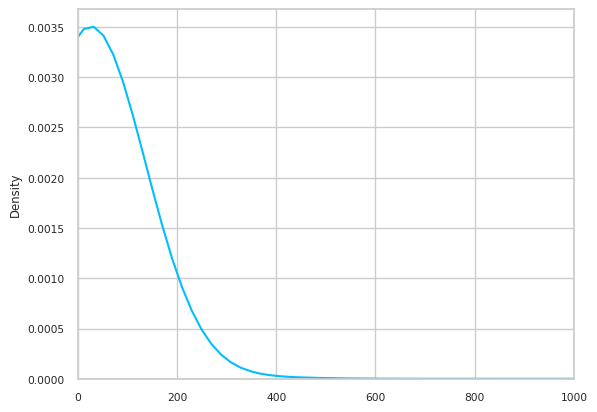

In [58]:
# _, losses = predict(model, train_dataset)
_, losses = predict(model, test_anomaly_dataset)
plt.xlim(0, 1000)
sns.kdeplot(losses)

## Predictions

Compute THRESHOLD with training set data

In [59]:
predictions, losses = predict(model, train_dataset)

In [60]:
loss_array = np.array(losses)

In [113]:
stdev = np.std(loss_array)
mean = np.mean(loss_array)
THRESHOLD = mean + stdev * 1

Check on test_normal_dataset

In [114]:
_, losses = predict(model, test_normal_dataset)
exceed_count = sum(l > THRESHOLD for l in losses)
print(f'number of intervals exceeding std dev loss: {exceed_count}/{len(test_normal_dataset)}')

number of intervals exceeding std dev loss: 28/416


Check on test_anomaly_dataset

In [115]:
_, losses = predict(model, test_anomaly_dataset)
exceed_count = sum(l > THRESHOLD for l in losses)
print(f'number of intervals exceeding std dev loss: {exceed_count}/{len(test_anomaly_dataset)}')

number of intervals exceeding std dev loss: 214/1000


## plot construction error vs original

In [122]:
def plot_prediction(data, model, title, ax, picker):
    predictions, pred_losses = predict(model, [data])

    ax.scatter(range(60), data[:,picker], label='true')
    ax.scatter(range(60), predictions[0].reshape(60,5)[:,picker], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

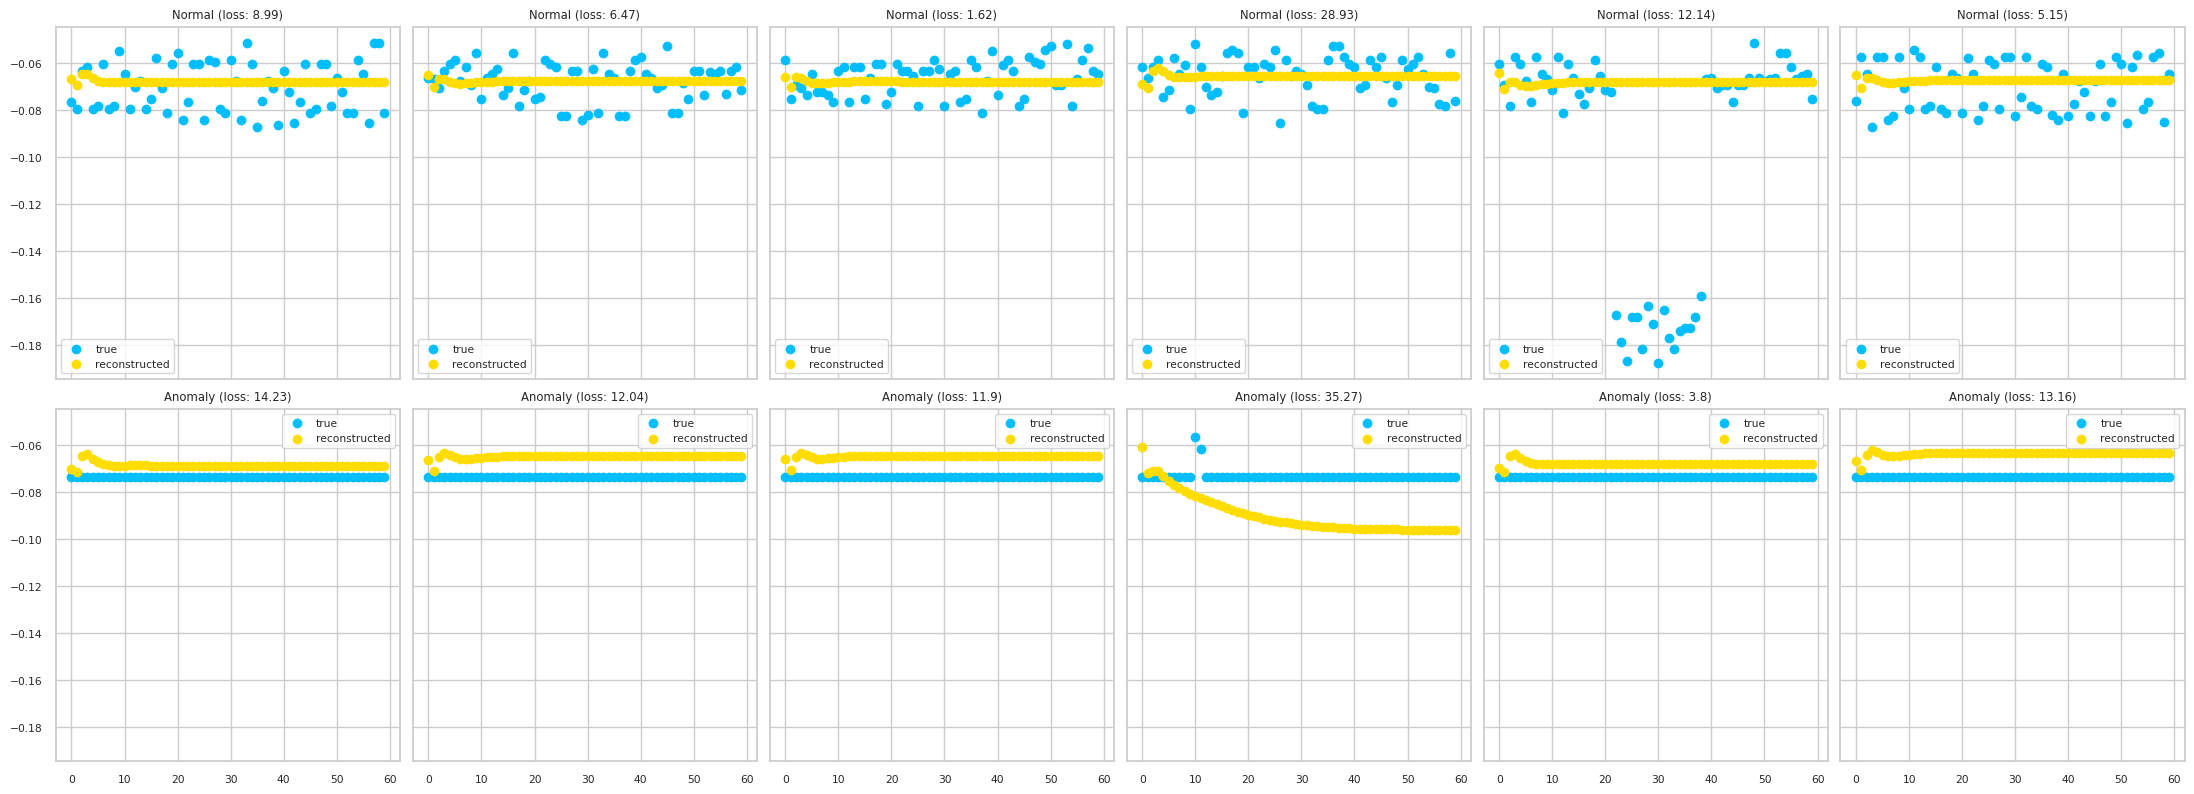

In [126]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22, 8)
)

picker = 4
sample_size = 6
sample_indices = random.sample(range(0,len(test_normal_dataset)), sample_size)

sampled_test_normal_dataset = [test_normal_dataset[i] for i in sample_indices]
sampled_test_anomaly_dataset = [test_anomaly_dataset[i] for i in sample_indices]

for i, data in enumerate(sampled_test_normal_dataset):
    plot_prediction(data, model, title='Normal', ax=axs[0, i], picker=picker)

for i, data in enumerate(sampled_test_anomaly_dataset):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i], picker=picker)

fig.tight_layout();

## Assess quality of prediction of flagged intervals

In [206]:

def convert_values(values):
    numerical_values = []
    for value in values:
        if value == 'False':
            numerical_values.append(0)
        elif value == 'True':
            numerical_values.append(1)
        else:
            # numerical_values.append(np.nan)
            # numerical_values.append(-1)
            numerical_values.append(-1)
    return numerical_values


fault_data = convert_values(df['BATT_PACK_1_FAULT']
                            .filter(filter_condition))


In [101]:
# we want to identify the count of anomalies in each interval in the "test_anomaly_dataset"
fault_segments = [ fault_data[i:i + seq_len] for i in range(0, len(anomaly_data) - seq_len + 1 ,seq_len) ]
# len(test_anomaly_dataset)
# count all occurances of 1 in fault_segments[i]
anomaly_count_list = [ fault_segments[i].count(1) for i in range(len(fault_segments))]
anomaly_flag_actual = [ count > 0 for count in anomaly_count_list ]

In [127]:
_, losses = predict(model, test_anomaly_dataset)

In [128]:
anomaly_flag_prediction = [ l > THRESHOLD for l in losses ]

In [129]:
sum(np.array(anomaly_flag_prediction))

214

In [130]:
result_mat = confusion_matrix(anomaly_flag_actual, anomaly_flag_prediction)

In [131]:
print(result_mat)

[[759 172]
 [ 27  42]]


In [132]:
tn, fp, fn, tp = result_mat.ravel()
print(tp, fn, fp, tn)
print(tn + fn )
print(fp + tp)

#                     actual negative actual positive 
# predicted negative: tn fp
# predicted positive: fn tp

42 27 172 759
786
214


In [133]:
# accuracy of negatives
specificity = tn / (tn + fp)
print(specificity)

# accuracy of positives
sensitivity = tp / (tp + fn)
print(sensitivity)


overall_accuracy = (tn + tp) / (tn + fp + fn + tp)
print(overall_accuracy)

0.8152524167561761
0.6086956521739131
0.801


In [135]:
print(f"only {tp / (fp + tp) * 100} of flagged intervals are actual")

only 19.626168224299064 of flagged intervals are actual


In [136]:
tp / (fn + tp)

0.6086956521739131

## plot regions of predicted anomalies

### juxtapose over anomalous region

In [155]:
_, losses = predict(model, test_anomaly_dataset)

In [219]:
anomaly_flag_prediction = [ l > THRESHOLD for l in losses ]

In [220]:
x_segments = []
count = 0
for i in anomaly_flag_prediction:
    count = count + 1
    x_segments.append([count*60, count*60 + 60])
y_segments = [ [0,0] for i in x_segments]

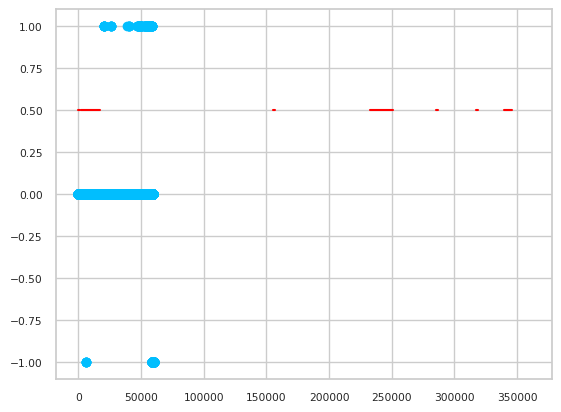

In [221]:
# fault region
# fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,3 * 2))

fig, ax = plt.subplots()
fault_incidents = fault_data[0:60000]
ax.scatter(range(len(fault_incidents)), fault_incidents)
true_color ="green"
false_color = "red"

labels = anomaly_flag_prediction
sequences = x_segments

y_level = 0.5
for i, (sequence, label) in enumerate(zip(sequences, labels)):
    if label:
        ax.plot((sequence[0],sequence[1]), (y_level,y_level), color="red")



### juxtapose over whole dataset

In [63]:
_, losses = predict(model, whole_dataset)

In [64]:
anomaly_flag_prediction = [ l > THRESHOLD for l in losses ]
x_segments = []
count = 0
for i in anomaly_flag_prediction:
    count = count + 1
    x_segments.append([count*60, count*60 + 60])
y_segments = [ [0,0] for i in x_segments]

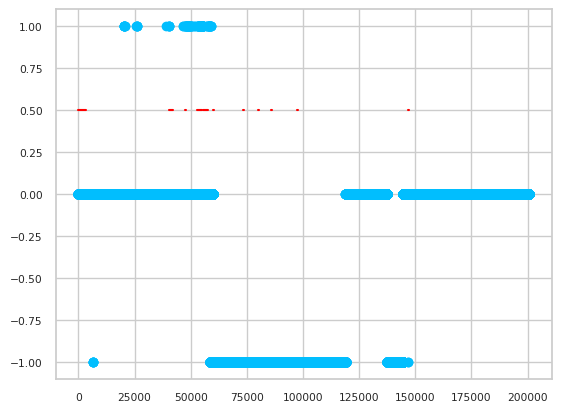

In [65]:
# fault region
# fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,3 * 2))

fig, ax = plt.subplots()
fault_incidents = fault_data
ax.scatter(range(len(fault_incidents)), fault_incidents)
true_color ="green"
false_color = "red"

labels = anomaly_flag_prediction
sequences = x_segments

y_level = 0.5
for i, (sequence, label) in enumerate(zip(sequences, labels)):
    if label:
        ax.plot((sequence[0],sequence[1]), (y_level,y_level), color="red")

